In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [2]:
!git clone https://github.com/WongKinYiu/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 668, done.
remote: Counting objects: 100% (290/290), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 668 (delta 222), reused 199 (delta 199), pack-reused 378
Receiving objects: 100% (668/668), 3.22 MiB | 10.65 MiB/s, done.
Resolving deltas: 100% (269/269), done.
/content/yolov9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.2 MB/s eta 0:00:00


In [3]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt

In [4]:
!ls -la {HOME}/weights

total 237680
drwxr-xr-x 2 root root      4096 May  7 04:06 .
drwxr-xr-x 1 root root      4096 May  7 04:06 ..
-rw-r--r-- 1 root root 103153312 Feb 18 12:36 yolov9-c.pt
-rw-r--r-- 1 root root 140217688 Feb 18 12:36 yolov9-e.pt


In [5]:
%%capture
#!pip install -U datasets
!pip install transformers==4.18.0 nltk==3.2.4 datasets==2.1.0 pandas==1.3.5

In [6]:
!pip install transformers datasets torch torchvision nltk sklearn

import os
import torch
import numpy as np
from PIL import Image
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from transformers import AutoTokenizer, AutoFeatureExtractor, AutoModel, AutoConfig, TrainingArguments, Trainer, logging
from datasets import load_dataset, set_caching_enabled
from sklearn.metrics import accuracy_score, f1_score
import nltk
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Environment setup for tokenizers
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Ensure nltk datasets are available
nltk.download('wordnet')

# Function to ensure WordNet is available in the expected directory
def ensure_wordnet():
    try:
        nltk.data.find('corpora/wordnet')
    except LookupError:
        nltk.download('wordnet', download_dir='/content/nltk_data/')
        os.system('unzip /content/nltk_data/corpora/wordnet.zip -d /content/nltk_data/corpora')
        nltk.data.path.append('/content/nltk_data/')

# Call the function to ensure WordNet
ensure_wordnet()

# Import WordNet
from nltk.corpus import wordnet

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package wordnet to /content/nltk_data/...


In [7]:
# cache for Hugging Face Transformers and Datasets.
os.environ['HF_HOME'] = os.path.join(".", "cache")

set_caching_enabled(True)
logging.set_verbosity_error()


In [8]:
#check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))


cuda
Tesla T4


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# load dataset from CSV files for training and testing
dataset = load_dataset(
    "csv",
    data_files={
        "train": "/content/drive/MyDrive/archive (3)/data.csv",
        "test": "/content/drive/MyDrive/archive (3)/data_eval.csv"
    }
)

# read answer space from file and split into an array by line
with open("/content/drive/MyDrive/archive (3)/answer_space.txt") as f:
    answer_space = f.read().splitlines()

# label each item in the dataset with their respective answers
dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0])  # select the 1st answer if multiple answers are provided
            for ans in examples['answer']
        ]
    },
    batched=True
)


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-f28045c84c4d0b62/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

detect_dual: weights=['/content/weights/yolov9-c.pt'], source=/content/drive/MyDrive/archive (3)/images/image1302.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=image1302, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 v0.1-89-g93f1a28 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 604 layers, 50880768 parameters, 0 gradients, 237.6 GFLOPs
image 1/1 /content/drive/MyDrive/archive (3)/images/image1302.png: 512x640 2 chairs, 1 couch, 2 potted plants, 1 book, 470.8ms
Speed: 3.1ms pre-process, 470.8ms inference, 1175.2ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/image1302


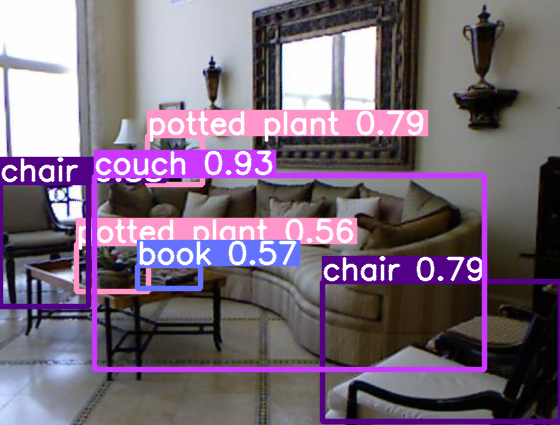

Question:	 what is the largest object
Answer:		 sofa (Label: 452)


'sofa'

In [11]:
import IPython.display as display
import os

def show_example(train=True, idx=None):
    dataset_type = "train" if train else "test"
    data = dataset[dataset_type]

    if idx is None:
        idx = np.random.randint(len(data))

    # YOLOv9 detect ===
    !python detect_dual.py \
    --source "/content/drive/MyDrive/archive (3)/images/{data[idx]['image_id']}.png" \
    --img 640 \
    --conf 0.3 \
    --device 0 \
    --weights "/content/weights/yolov9-c.pt" \
    --name {data[idx]['image_id']}
    # =====

    image_path =  "/content/yolov9/runs/detect/" + f"{data[idx]['image_id']}/{data[idx]['image_id']}.png"
    image = Image.open(image_path)
    display.display(image)

    question = data[idx]["question"]
    answer = data[idx]["answer"]
    label = data[idx]["label"]

    # Delete files from detect
    !rm -rf "/content/yolov9/runs/detect/{data[idx]['image_id']}"

    print(f"Question:\t {question}")
    print(f"Answer:\t\t {answer} (Label: {label})")

    return answer

show_example()


### Let's view some data

In [12]:
# load dataset from CSV files for training and testing
dataset = load_dataset(
    "csv",
    data_files={
        "train": "/content/drive/MyDrive/archive (3)/data_train.csv",
        "test": "/content/drive/MyDrive/archive (3)/data_eval.csv"
    }
)

# read answer space from file and split into an array by line
with open("/content/drive/MyDrive/archive (3)/answer_space.txt") as f:
    answer_space = f.read().splitlines()

# label each item in the dataset with their respective answers
dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0])  # select the 1st answer if multiple answers are provided
            for ans in examples['answer']
        ]
    },
    batched=True
)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-57821f04fd98b206/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [13]:
@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor

    def tokenize_text(self, texts: List[str]) -> Dict[str, torch.Tensor]:
        """
        Tokenize text inputs and return relevant tokenized information.
        """
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }

    def preprocess_images(self, images: List[str]) -> Dict[str, torch.Tensor]:
        """
        Extract features from images and return the processed pixel values.
        """
        processed_images = self.preprocessor(
            images=[
                Image.open(os.path.join("/content/drive/MyDrive/archive (3)/images/", f"{image_id}.png")).convert('RGB')
                for image_id in images
            ],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }

    def __call__(self, raw_batch_dict) -> Dict[str, torch.Tensor]:
        """
        Process raw batch data, tokenize text and extract image features, returning a dictionary
        containing processed inputs and labels.
        """
        question_batch = raw_batch_dict['question'] if isinstance(raw_batch_dict, dict) else [i['question'] for i in raw_batch_dict]
        image_id_batch = raw_batch_dict['image_id'] if isinstance(raw_batch_dict, dict) else [i['image_id'] for i in raw_batch_dict]
        label_batch = raw_batch_dict['label'] if isinstance(raw_batch_dict, dict) else [i['label'] for i in raw_batch_dict]

        return {
            **self.tokenize_text(question_batch),
            **self.preprocess_images(image_id_batch),
            'labels': torch.tensor(label_batch, dtype=torch.int64),
        }


In [14]:
import torch.nn as nn


In [15]:
class MultimodalVQAModel(nn.Module):
    def __init__(
        self,
        num_labels: int = len(answer_space),
        intermediate_dim: int = 512,
        pretrained_text_name: str = 'bert-base-uncased',
        pretrained_image_name: str = 'google/vit-base-patch16-224-in21k'
    ):
        """
        Initializes the Multimodal VQA Model.

        Args:
            num_labels (int): Number of labels in the answer space.
            intermediate_dim (int): Dimensionality of the intermediate layer in the fusion module.
            pretrained_text_name (str): Pretrained name for the text encoder.
            pretrained_image_name (str): Pretrained name for the image encoder.
        """
        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name

        # Text and image encoders

        self.text_encoder = AutoModel.from_pretrained(self.pretrained_text_name)
        self.image_encoder = AutoModel.from_pretrained(self.pretrained_image_name)

        # Fusion module
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

        # Classifier
        self.classifier = nn.Linear(intermediate_dim, self.num_labels)

        # Loss function
        self.criterion = nn.CrossEntropyLoss()

    def forward(
        self,
        input_ids: torch.LongTensor,
        pixel_values: torch.FloatTensor,
        attention_mask: Optional[torch.LongTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        labels: Optional[torch.LongTensor] = None
    ):
        """
        Forward pass of the model.

        Args:
            input_ids (torch.LongTensor): Tokenized input IDs for text.
            pixel_values (torch.FloatTensor): Pixel values for images.
            attention_mask (Optional[torch.LongTensor]): Attention mask for text.
            token_type_ids (Optional[torch.LongTensor]): Token type IDs for text.
            labels (Optional[torch.LongTensor]): Ground truth labels.

        Returns:
            Dict: Dictionary containing model outputs, including logits. If labels are provided, also includes loss.
        """
        # Encode text with masking
        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )

        # Encode images
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )

        # Combine encoded texts and images
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )

        # Make predictions
        logits = self.classifier(fused_output)

        out = {"logits": logits}
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss

        return out


In [16]:
def create_multimodal_vqa_collator_and_model(text_encoder='bert-base-uncased', image_encoder='google/vit-base-patch16-224-in21k'):
    """
    Creates a Multimodal VQA collator and model.

    Args:
        text_encoder (str): Pretrained name for the text encoder.
        image_encoder (str): Pretrained name for the image encoder.

    Returns:
        Tuple: Multimodal collator and VQA model.
    """
    # Initialize tokenizer and feature extractor
    tokenizer = AutoTokenizer.from_pretrained(text_encoder)
    preprocessor = AutoFeatureExtractor.from_pretrained(image_encoder)

    # Create Multimodal Collator
    multimodal_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )

    # Create Multimodal VQA Model
    multimodal_model = MultimodalVQAModel(
        pretrained_text_name=text_encoder,
        pretrained_image_name=image_encoder
    ).to(device)

    return multimodal_collator, multimodal_model


In [17]:
def wup_measure(a, b, similarity_threshold=0.925):
    """
    Computes the Wu-Palmer similarity score between two words or phrases.

    Args:
        a (str): First word or phrase.
        b (str): Second word or phrase.
        similarity_threshold (float): Threshold for similarity to consider semantic fields.

    Returns:
        float: Wu-Palmer similarity score.
    """
    def get_semantic_field(word):
        """
        Retrieves the semantic field for a word.

        Args:
            word (str): Word to retrieve the semantic field for.

        Returns:
            Tuple: Tuple containing the semantic field and weight.
        """
        weight = 1.0
        semantic_field = wordnet.synsets(word, pos=wordnet.NOUN)
        return semantic_field, weight

    def get_stem_word(word):
        """
        Processes words in the form 'word\d+:wordid' by returning the word and downweighting.

        Args:
            word (str): Word to process.

        Returns:
            Tuple: Tuple containing the processed word and weight.
        """
        weight = 1.0
        return word, weight

    global_weight = 1.0

    # Get stem words and weights
    a, global_weight_a = get_stem_word(a)
    b, global_weight_b = get_stem_word(b)
    global_weight = min(global_weight_a, global_weight_b)

    # Check if words are the same
    if a == b:
        return 1.0 * global_weight

    # Check for empty strings
    if a == "" or b == "":
        return 0

    # Get semantic fields and weights
    interp_a, weight_a = get_semantic_field(a)
    interp_b, weight_b = get_semantic_field(b)

    # Check for empty semantic fields
    if interp_a == [] or interp_b == []:
        return 0

    # Find the most optimistic interpretation
    global_max = 0.0
    for x in interp_a:
        for y in interp_b:
            local_score = x.wup_similarity(y)
            if local_score > global_max:
                global_max = local_score

    # Use semantic fields and downweight unless the score is high (indicating synonyms)
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score = global_max * weight_a * weight_b * interp_weight * global_weight
    return final_score

def batch_wup_measure(labels, preds):
    """
    Computes the average Wu-Palmer similarity score for a batch of predicted and ground truth labels.

    Args:
        labels (List): List of ground truth labels.
        preds (List): List of predicted labels.

    Returns:
        float: Average Wu-Palmer similarity score for the batch.
    """
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)


In [18]:
labels = np.random.randint(len(answer_space), size=5)
preds = np.random.randint(len(answer_space), size=5)

def showAnswers(ids):
    print([answer_space[id] for id in ids])

showAnswers(labels)
showAnswers(preds)

print("Predictions vs Labels: ", batch_wup_measure(labels, preds))
print("Labels vs Labels: ", batch_wup_measure(labels, labels))

['stove_burner', 'towel', 'books', 'garbage_bin', 'letter_stand']
['room_divider', 'bathtub', 'paper', 'hair_dryer', 'flower_pot']
Predictions vs Labels:  0.029264705882352943
Labels vs Labels:  1.0


In [19]:
def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    """
    Computes evaluation metrics for a given set of logits and labels.

    Args:
        eval_tuple (Tuple): Tuple containing logits and corresponding ground truth labels.

    Returns:
        Dict: Dictionary of computed metrics, including WUP similarity, accuracy, and F1 score.
    """
    logits, labels = eval_tuple

    # Calculate predictions
    preds = logits.argmax(axis=-1)

    # Compute metrics
    metrics = {
        "wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro')
    }

    return metrics


# Train the model and evaluate

In [20]:
# Define training arguments for the model

args = TrainingArguments(
    output_dir="/content/checkpoint/",            # Output directory for checkpoints and logs=
    seed=12345,                         # Seed for reproducibility
    evaluation_strategy="epoch",        # Evaluation strategy: "steps" or "epoch"
    eval_steps=100,                     # Evaluate every 100 steps
    logging_strategy="epoch",           # Logging strategy: "steps" or "epoch"
    logging_steps=100,                  # Log every 100 steps
    save_strategy="epoch",              # Saving strategy: "steps" or "epoch"
    save_steps=100,                     # Save every 100 steps
    save_total_limit=3,                 # Save only the last 3 checkpoints at any given time during training
    metric_for_best_model='wups',       # Metric used for determining the best model
    per_device_train_batch_size=32,     # Batch size per GPU for training
    per_device_eval_batch_size=32,      # Batch size per GPU for evaluation
    remove_unused_columns=False,        # Whether to remove unused columns in the dataset
    num_train_epochs=2,                 # Number of training epochs
    fp16=True,                          # Enable mixed precision training (float16)
    dataloader_num_workers=8,           # Number of workers for data loading
    load_best_model_at_end=True,        # Whether to load the best model at the end of training
)




In [21]:

import os

# Install wandb library
!pip install wandb

import wandb

# Set W&B API key
os.environ["WANDB_API_KEY"] = "f5471f8f32e9138b794780c29155496160e73475"

# Log in to W&B
wandb.login()

# Check W&B status
!wandb status


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 15.3 MB/s eta 0:00:00


wandb: Currently logged in as: dattatraykhansole (project_major). Use `wandb login --relogin` to force relogin


Current Settings
{
  "_extra_http_headers": null,
  "_proxies": null,
  "api_key": null,
  "base_url": "https://api.wandb.ai",
  "entity": null,
  "git_remote": "origin",
  "ignore_globs": [],
  "project": null,
  "root_dir": null,
  "section": "default"
}


In [22]:
def create_and_train_model(dataset, args, text_model='bert-base-uncased', image_model='google/vit-base-patch16-224-in21k', multimodal_model='bert_vit'):
    """
    Creates a Multimodal VQA collator and model, and trains the model using the provided dataset and training arguments.

    Args:
        dataset (Dict): Dictionary containing 'train' and 'test' datasets.
        args (TrainingArguments): Training arguments for the model.
        text_model (str): Pretrained name for the text encoder.
        image_model (str): Pretrained name for the image encoder.
        multimodal_model (str): Name for the multimodal model.

    Returns:
        Tuple: Collator, model, training metrics, and evaluation metrics.
    """
    # Create Multimodal Collator and Model
    collator, model = create_multimodal_vqa_collator_and_model(text_model, image_model)

    # Create a copy of arguments and set the output directory
    multi_args = deepcopy(args)
    multi_args.output_dir = os.path.join("/content/checkpoint/", multimodal_model)
    print(multi_args.output_dir)
    # Create Trainer for Multimodal Model
    multi_trainer = Trainer(
        model,
        multi_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        data_collator=collator,
        compute_metrics=compute_metrics
    )

    # Train and evaluate for metrics
    train_multi_metrics = multi_trainer.train()
    eval_multi_metrics = multi_trainer.evaluate()

    return collator, model, train_multi_metrics, eval_multi_metrics, multi_trainer


In [23]:
collator, model, train_multi_metrics, eval_multi_metrics, trainer = create_and_train_model(dataset, args)


Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Using amp half precision backend


/content/checkpoint/bert_vit


***** Running training *****
  Num examples = 6795
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 426
***** Running Evaluation *****
  Num examples = 5673
  Batch size = 32


{'loss': 5.3324, 'learning_rate': 2.511737089201878e-05, 'epoch': 1.0}


Saving model checkpoint to /content/checkpoint/bert_vit/checkpoint-213
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.627334117889404, 'eval_wups': 0.1711226224986738, 'eval_acc': 0.10999471179270227, 'eval_f1': 0.0024375920200066987, 'eval_runtime': 125.4069, 'eval_samples_per_second': 45.237, 'eval_steps_per_second': 1.419, 'epoch': 1.0}


***** Running Evaluation *****
  Num examples = 5673
  Batch size = 32


{'loss': 4.6533, 'learning_rate': 1.1737089201877935e-07, 'epoch': 2.0}


Saving model checkpoint to /content/checkpoint/bert_vit/checkpoint-426
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.437163829803467, 'eval_wups': 0.18802861705331492, 'eval_acc': 0.1274457958751983, 'eval_f1': 0.004390268764403052, 'eval_runtime': 124.3981, 'eval_samples_per_second': 45.604, 'eval_steps_per_second': 1.431, 'epoch': 2.0}




Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /content/checkpoint/bert_vit/checkpoint-426 (score: 0.18802861705331492).
***** Running Evaluation *****
  Num examples = 5673
  Batch size = 32


{'train_runtime': 571.8837, 'train_samples_per_second': 23.764, 'train_steps_per_second': 0.745, 'train_loss': 4.992887971546728, 'epoch': 2.0}
{'eval_loss': 4.437163829803467, 'eval_wups': 0.18802861705331492, 'eval_acc': 0.1274457958751983, 'eval_f1': 0.004390268764403052, 'eval_runtime': 121.2735, 'eval_samples_per_second': 46.779, 'eval_steps_per_second': 1.468, 'epoch': 2.0}


In [24]:
eval_multi_metrics

{'eval_loss': 4.437163829803467,
 'eval_wups': 0.18802861705331492,
 'eval_acc': 0.1274457958751983,
 'eval_f1': 0.004390268764403052,
 'eval_runtime': 121.2735,
 'eval_samples_per_second': 46.779,
 'eval_steps_per_second': 1.468,
 'epoch': 2.0}

In [25]:
import os

# Define the checkpoint folder path
checkpoint_folder = "/content/checkpoint/bert_vit/"

# Create the directory if it doesn't exist
os.makedirs(checkpoint_folder, exist_ok=True)



# Get a list of all subdirectories in the checkpoint folder
all_subdirectories = [d for d in os.listdir(checkpoint_folder) if os.path.isdir(os.path.join(checkpoint_folder, d))]

# Filter only subdirectories starting with "checkpoint-"
checkpoint_subdirectories = [d for d in all_subdirectories if d.startswith("checkpoint-")]

# Extract the checkpoint numbers from the subdirectory names
checkpoint_numbers = [int(d.split("-")[1]) for d in checkpoint_subdirectories]

# Find the latest checkpoint number
latest_checkpoint_number = max(checkpoint_numbers, default=0)

# Construct the path for the latest checkpoint
latest_checkpoint_path = os.path.join(checkpoint_folder, f"checkpoint-{latest_checkpoint_number}/pytorch_model.bin")

print("Latest Checkpoint Number:", latest_checkpoint_number)
print("Latest Checkpoint Path:", latest_checkpoint_path)


Latest Checkpoint Number: 426
Latest Checkpoint Path: /content/checkpoint/bert_vit/checkpoint-426/pytorch_model.bin


In [26]:
model = MultimodalVQAModel()
model.load_state_dict(torch.load(latest_checkpoint_path))
model.to(device)


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

MultimodalVQAModel(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [27]:
import random

# Randomly sample 10 indices from the test dataset
random_sample_indices = random.sample(range(len(dataset["test"])), k=10)

# Sample data for manual testing
sample = collator([dataset["test"][index] for index in random_sample_indices])

# Extract input components from the sample for manual testing
input_ids = sample["input_ids"].to(device)
token_type_ids = sample["token_type_ids"].to(device)
attention_mask = sample["attention_mask"].to(device)
pixel_values = sample["pixel_values"].to(device)
labels = sample["labels"].to(device)


In [28]:
# Set the model to evaluation mode
model.eval()

# Forward pass with the sample data
output = model(input_ids, pixel_values, attention_mask, token_type_ids, labels)


In [29]:
# Get predictions from the model output
predictions = output["logits"].argmax(axis=-1).cpu().numpy()
predictions


array([308, 568, 483, 564, 483, 483, 483, 308, 564,  10])

[nltk_data] Downloading package wordnet to /content/nltk_data/...
[nltk_data]   Package wordnet is already up-to-date!


detect_dual: weights=['/content/weights/yolov9-c.pt'], source=/content/drive/MyDrive/archive (3)/images/image774.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=image774, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 v0.1-89-g93f1a28 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 604 layers, 50880768 parameters, 0 gradients, 237.6 GFLOPs
image 1/1 /content/drive/MyDrive/archive (3)/images/image774.png: 512x640 3 bottles, 1 oven, 1 sink, 1 refrigerator, 521.2ms
Speed: 1.0ms pre-process, 521.2ms inference, 1961.9ms NMS 

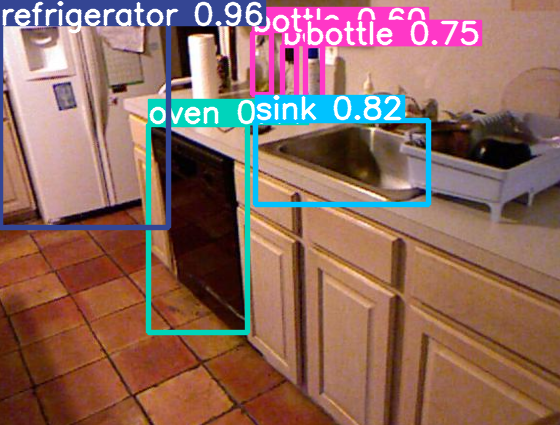

Question:	 what is on the left side of the container
Answer:		 bottle_of_hand_wash_liquid (Label: 64)
Predicted Answer:	 room_divider
Similarity: 0.3745214752567693




detect_dual: weights=['/content/weights/yolov9-c.pt'], source=/content/drive/MyDrive/archive (3)/images/image774.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=image774, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 v0.1-89-g93f1a28 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 604 layers, 50880768 parameters, 0 gradients, 237.6 GFLOPs
image 1/1 /content/drive/MyDrive/archive (3)/images/image774.png: 512x640 3 bottles, 1 oven, 1 sink, 1 refrigerator, 265.5ms
Speed: 0.8

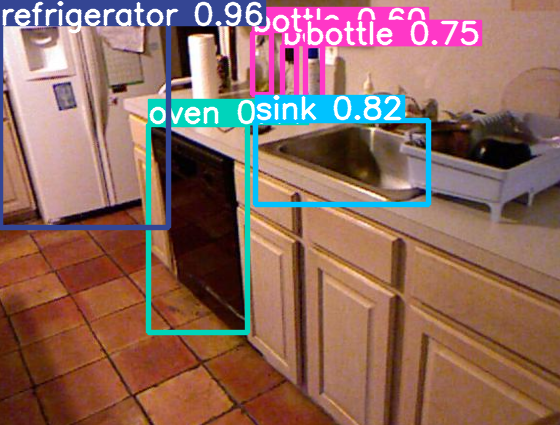

Question:	 what is on the right side of the tap
Answer:		 kitchen_utensils (Label: 301)
Predicted Answer:	 bathtub
Similarity: 0.630718954248366




detect_dual: weights=['/content/weights/yolov9-c.pt'], source=/content/drive/MyDrive/archive (3)/images/image775.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=image775, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 v0.1-89-g93f1a28 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 604 layers, 50880768 parameters, 0 gradients, 237.6 GFLOPs
image 1/1 /content/drive/MyDrive/archive (3)/images/image775.png: 512x640 2 bottles, 1 oven, 1 sink, 1 refrigerator, 1 book, 166.5ms
Speed: 0.6ms pre-proce

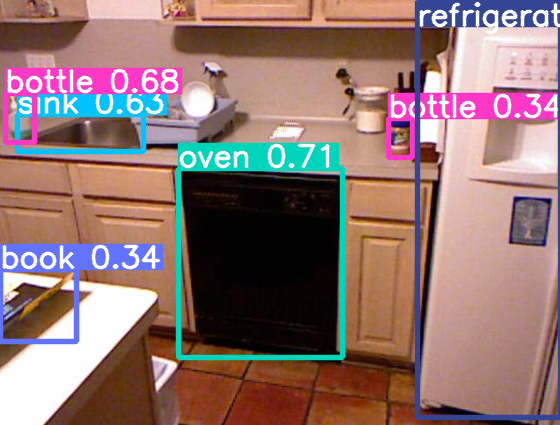

Question:	 what is on the right side of the cellphone charger
Answer:		 plastic_box (Label: 393)
Predicted Answer:	 paper
Similarity: 0.41558441558441556




detect_dual: weights=['/content/weights/yolov9-c.pt'], source=/content/drive/MyDrive/archive (3)/images/image775.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=image775, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 v0.1-89-g93f1a28 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 604 layers, 50880768 parameters, 0 gradients, 237.6 GFLOPs
image 1/1 /content/drive/MyDrive/archive (3)/images/image775.png: 512x640 2 bottles, 1 oven, 1 sink, 1 refrigerator, 1 book, 185.8ms
Speed: 0.6ms 

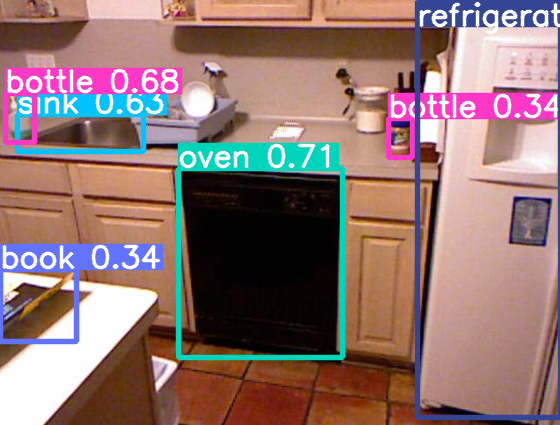

Question:	 what is on the right side of the plastic box
Answer:		 knife_rack, knife (Label: 303)
Predicted Answer:	 hair_dryer
Similarity: 0.4509991556431185




detect_dual: weights=['/content/weights/yolov9-c.pt'], source=/content/drive/MyDrive/archive (3)/images/image775.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=image775, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 v0.1-89-g93f1a28 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 604 layers, 50880768 parameters, 0 gradients, 237.6 GFLOPs
image 1/1 /content/drive/MyDrive/archive (3)/images/image775.png: 512x640 2 bottles, 1 oven, 1 sink, 1 refrigerator, 1 book, 265.4ms
Speed: 0.

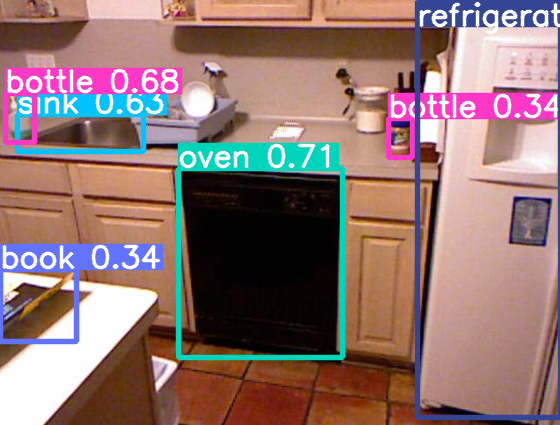

Question:	 what is behind the kitchen utensils
Answer:		 bottle_of_liquid (Label: 65)
Predicted Answer:	 flower_pot
Similarity: 0.44771241830065356




In [30]:
import nltk
import os

# Set NLTK data directory explicitly
nltk.data.path.append("/content/nltk_data/")

# Reinitialize NLTK data directory
nltk.download('wordnet', download_dir="/content/nltk_data/")

def similarity(a, b):
    # Split words if it is a list and remove extra spaces
    words_a = [w.strip() for w in a.split(',')]
    words_b = [w.strip() for w in b.split(',')]

    # Split words if connected by underscore _
    a = [w_ for word in words_a for w_ in word.split('_')]
    b = [w_ for word in words_b for w_ in word.split('_')]

    res = 0
    n = 0

    # Calculate score and take average
    for i in a:
        synsets_i = wordnet.synsets(i)
        if synsets_i:
            s1 = synsets_i[0]
            for j in b:
                synsets_j = wordnet.synsets(j)
                if synsets_j:
                    s2 = synsets_j[0]
                    sim = s1.wup_similarity(s2)
                    if sim:
                        res += sim
                    n += 1

    return res / n if n != 0 else 0

# Show predictions for a range of examples
for i in range(2000, 2005):
    print("\n=========================================================\n")
    real_answer = show_example(train=False, idx=i)
    predicted_answer = answer_space[preds[i - 2000]]
    print("Predicted Answer:\t", predicted_answer)
    print(f"Similarity: {similarity(real_answer, predicted_answer)}")
    print("\n=========================================================\n")


F1 Score: 0.7778
Accuracy: 0.8000
Recall: 0.8333


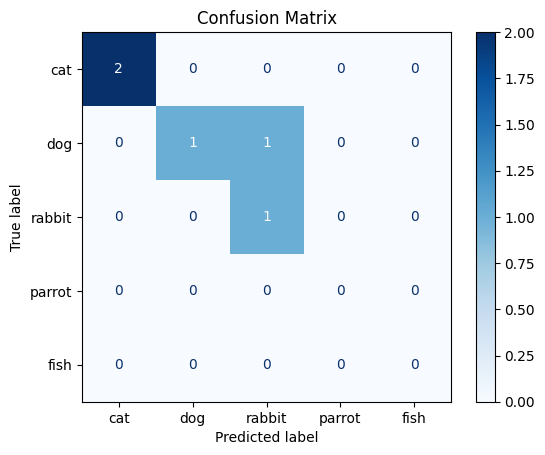

In [32]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# Dummy data for illustration
answer_space = ['cat', 'dog', 'rabbit', 'parrot', 'fish']  # Example classes
real_answers = ['cat', 'dog', 'rabbit', 'cat', 'dog']  # Actual answers
predicted_answers = ['cat', 'rabbit', 'rabbit', 'cat', 'dog']  # Predictions made by the model

# Convert textual answers to indices for metric calculation
real_indices = [answer_space.index(ans) for ans in real_answers if ans in answer_space]
predicted_indices = [answer_space.index(ans) for ans in predicted_answers if ans in answer_space]

# Calculate F1 score
f1 = f1_score(real_indices, predicted_indices, average='macro')
print(f"F1 Score: {f1:.4f}")

# Calculate Accuracy
accuracy = accuracy_score(real_indices, predicted_indices)
print(f"Accuracy: {accuracy:.4f}")

# Calculate Recall
recall = recall_score(real_indices, predicted_indices, average='macro')
print(f"Recall: {recall:.4f}")

# Calculate and Display Confusion Matrix
cm = confusion_matrix(real_indices, predicted_indices, labels=range(len(answer_space)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=answer_space)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [33]:
def count_trainable_parameters(model):
    """
    Count and print the number of trainable parameters in a PyTorch model.

    Args:
        model (torch.nn.Module): The PyTorch model.

    Returns:
        None
    """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Number of trainable parameters: {:,}".format(num_params))
count_trainable_parameters(model)

Number of trainable parameters: 196,956,998
